# CIFAR-100 Image Classification 
**_USYD COMP5318 Machine Learning Assignment_** <br>
**Topic**: CIFAR-100, classification, https://www.cs.toronto.edu/~kriz/cifar.html. <br>

**Date**: 1 NOV 2021 <br>

**System**:
- System: Mac Darwin <br>
- Machine: x86_64 <br>
- Processor: i386 <br>
- Memory: 8 GB <br>
- CPU: 8-core <br>
- GPU: Python 3 Google Compute Engine backend <br>


# 1. Import images

There are 2 image datasets namely train and test which stored in numpy array. Load data from keras library which will download data from https://www.cs.toronto.edu/~kriz/cifar.html 


In [1]:
!pip install pyyaml h5py

import os
import pickle
import numpy as np
from tensorflow.keras.datasets import cifar100

#=================================
# a. Load data from Keras 
#=================================
def load_from_keras():
  # log
  print("load_from_keras(): start loading ... ")
  
  # load directly from package 
  (x_train,y_train), (x_test, y_test) = cifar100.load_data()
  return (x_train,y_train), (x_test, y_test)

#===========
# Load data 
#===========
(x_train, y_train), (x_test, y_test) = load_from_keras()

# describe data
print("load_data(): train_data loaded, " + str(x_train.shape))
print("load_data(): train_label loaded, " + str(len(y_test)))
print("load_data(): test_data loaded, " + str(x_test.shape))
print("load_data(): test_label loaded, " + str(len(y_test)))

load_from_keras(): start loading ... 
169017344/169001437 [==============================] - 7s 0us/step
load_data(): train_data loaded, (50000, 32, 32, 3)
load_data(): train_label loaded, 10000
load_data(): test_data loaded, (10000, 32, 32, 3)
load_data(): test_label loaded, 10000


# 2. Preprocessing

###2.1 Global Helper functions
Include: GPU managment, image overview, Neural network helper functions. Please run these cells in numeric order before further execution. 
- **clear_ram()**: clear ram session and free ram memory 
- **plot_epoch_accuracy(record)**: plot training_accuracy and yest_accuracy by increase epoch 
- **show_img(x_train)**: show some (2*5) sample images

show_img(): show sample images ...


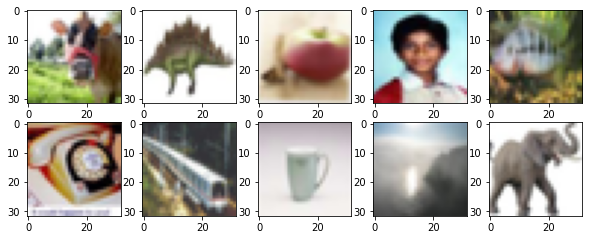

In [2]:
import gc 
from matplotlib import pyplot as plt
from tensorflow.compat.v1 import ConfigProto, Session
from tensorflow.compat.v1.keras.backend import get_session, clear_session, set_session

#========================
# Gpu session management
#========================
def clear_ram():
  # remove things in RAM
  session = get_session()
  clear_session()

  # Close existing session 
  session.close()
  session = tf.compat.v1.keras.backend.get_session()

  # Create new RAM session 
  config = ConfigProto()
  config.gpu_options.per_process_gpu_memory_fraction = 1
  config.gpu_options.visible_device_list = "0"
  set_session(Session(config=config))

#====================
# plot epoch diagram
#====================
# plot epoch and accuracy diagram for train and test
def plot_epoch_accuracy(record):
  plt.plot(record.history['accuracy'], label='Training')
  plt.plot(record.history['val_accuracy'], label = 'Testing')
  plt.xlabel('Epoches')
  plt.ylabel('Accuracy')
  #plt.imshow()
  plt.show()

# show an image 
def show_img(x_train):
  # 
  print("show_img(): show sample images ...")
  # set initial size 
  plt.figure(figsize=(10,10))

  # show 10 pictures in 1 grid
  for i in range(0,10):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    tmp = x_train[i]
    plt.imshow(tmp)
  plt.show()


# show sample images * 10
show_img(x_train)



#### 2.2 Preprocessing for Neural Networks <br>
Preprocessing for CNN and VGG16, and hot code y_train and y_test
- **normalisation()**: keep image pixels between 0 to 1 as float <br>
- **one_hot_code**: hot code all labels (y) <br>




In [3]:
# IF NO GPU DON'T RUN THIS 
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.compat.v1 import ConfigProto, Session
from tensorflow.compat.v1.keras.backend import get_session, clear_session, set_session

#===============
# Normalisation 
#===============
def normalisation(train, test):
  train = train - np.mean(train, axis = 0)
  train = train / np.std(train, axis = 0)
  test = test - np.mean(test, axis = 0)
  test = test / np.std(test, axis = 0)
  return (train, test)

#=====================
# One Hot Code labels
#=====================
from tensorflow.keras.utils import to_categorical
def one_hot_code(y_train, y_test):
  label1 = to_categorical(y_train, 100)
  label2 = to_categorical(y_test, 100)
  return label1, label2

#===========================
# Prepare image for Network 
#===========================

# if session exists close 
if (get_session()):
  session = get_session()
  session.close()

# else: create session 
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# normalisation 
NN_x_train, NN_x_test = normalisation(x_train, x_test)

# One hot code labels
NN_y_train, NN_y_test = one_hot_code(y_train, y_test)


# 3. Models
Model building functions.
- 3.1 LeNet-5
- 3.2 VGG-16

#### 3.1 LeNet-5

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization

# =====================
# Building LeNet Model
# =====================
def LeNet(drop = 0.5, summary = False):
  # CNN container 
  LeNet = Sequential()
  decay = 0.01
  
  # ==================================== Block 1 ==================================== 
  # Convo-1: filter = 64，kernel_size = 3*3
  LeNet.add(Conv2D(filters = 32, kernel_size = (5, 5), activation='relu', data_format='channels_last', padding='same', input_shape=(32,32,3)))
  LeNet.add(BatchNormalization())
  LeNet.add(Dropout(rate = drop))

  # Pooling-1: pool size = 2*2, trides=2
  LeNet.add(MaxPooling2D(pool_size = (2, 2), strides=(2,2), padding = 'same', name="Pooling-1"))

  # ==================================== Block 2 ====================================
  # Convo-2: filter = 128，kernel_size = 3*3
  LeNet.add(Conv2D(filters = 64, kernel_size = (5, 5), activation='relu', 
                   data_format='channels_last', padding='same', kernel_regularizer = l2(decay)))
  LeNet.add(BatchNormalization())
  LeNet.add(Dropout(rate = drop))

  LeNet.add(MaxPooling2D(pool_size = (2, 2), strides=(2,2), padding = 'same', name="Pooling-2"))

  # ==================================== Block 3 ==================================== 
  LeNet.add(Conv2D(filters = 128, kernel_size = (5, 5), activation='relu', 
                   data_format='channels_last', padding='same', kernel_regularizer = l2(decay)))
  LeNet.add(BatchNormalization())
  LeNet.add(Dropout(rate = drop))
  LeNet.add(MaxPooling2D(pool_size = (2, 2), strides=(2,2), padding = 'same', name="Pooling-3"))

  # ==================================== Block 3 ==================================== 

  LeNet.add(Flatten())
  LeNet.add(Dense(1024, activation=tf.nn.relu))
  LeNet.add(BatchNormalization())
  #LeNet.add(Dropout(rate = drop))
  LeNet.add(Dense(100, activation=tf.nn.softmax))

  if (summary == True):
    print(LeNet.summary())
  
  return LeNet

def train_LeNet(x_train, y_train, x_test, y_test, lenet, opt, batch_size = 125, max_epoch = 100, early_stop = True, plot = True, verb = 0):
  # steps 
  stp = x_train.shape[0] // batch_size
  
  #data augmentation = image rotation, hori/verti shift, hori/verti flip
  image_generator = ImageDataGenerator(
      rotation_range = 20, 
      width_shift_range = 0.1,
      height_shift_range = 0.1,
      horizontal_flip=True,
  )
  # train generator and produce flow 
  image_generator.fit(x_train)
  train = image_generator.flow(x_train, y_train, batch_size = batch_size)

  # early stopping to avoid waste time 
  early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 0, mode = 'auto')

  lenet.compile(loss = 'categorical_crossentropy',
              optimizer = opt, 
              metrics = ['accuracy'])

  # train model 
  if (early_stop == True):
    record = lenet.fit(train, steps_per_epoch = stp,
                     epochs = max_epoch,
                     validation_data = (x_test, y_test), 
                     callbacks = [early_stopping], 
                     shuffle = True,
                     verbose = verb)
  else:
    record = lenet.fit(train,
                     epochs = max_epoch,
                     validation_data = (x_test, y_test), 
                     shuffle = True,
                     verbose = verb)

  # Plot epoch diagram using helper function 
  if (plot == True):
    plot_epoch_accuracy(record) 
  
  return lenet, record

#### 3.2 VGG16

In [5]:
#========
# VGG-16
#========
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization

# Build VGG-16 model 
def VGG16(kernel = 3, decay = 0.0005, summary = False):
  # container 
  VGG16 = Sequential()

  # ==================================== Block 1 ====================================
  # Convo: filter = 64
  VGG16.add(Conv2D(filters = 64, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same',
                 input_shape = (32,32,3), kernel_regularizer = l2(decay), 
                 name="Convo-1-1"))
  # Normalisation 
  VGG16.add(BatchNormalization())
  # drop 30% 
  VGG16.add(Dropout(rate = 0.3, name = "Drop-1-1"))

  # Convo: filter = 64
  VGG16.add(Conv2D(filters = 64, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-1-2"))
  # Normalisation 
  VGG16.add(BatchNormalization())

  # Pooling-1: pool size = 2*2
  VGG16.add(MaxPooling2D(pool_size = (2, 2), name="Pooling-1-1"))

  # ==================================== Block 2 ====================================
  # Convo: filter = 128
  VGG16.add(Conv2D(filters = 128, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-2-1"))
  # Normalisation 
  VGG16.add(BatchNormalization())
  # drop 30% 
  VGG16.add(Dropout(rate = 0.4, name = "Drop-2-1"))

  # Convo: filter = 128
  VGG16.add(Conv2D(filters = 128, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-2-2"))
  # Normalisation 
  VGG16.add(BatchNormalization())

  # Pooling-2: pool size = 2*2
  VGG16.add(MaxPooling2D(pool_size = (2, 2), name="Pooling-2-1"))

  # ==================================== Block 3 ====================================
  # Convo: filter = 256
  VGG16.add(Conv2D(filters = 256, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-3-1"))
  # Normalisation 
  VGG16.add(BatchNormalization())
  # drop 40% 
  VGG16.add(Dropout(rate = 0.4, name = "Drop-3-1"))

  # Convo: filter = 256
  VGG16.add(Conv2D(filters = 256, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-3-2"))
  # Normalisation 
  VGG16.add(BatchNormalization())
  # drop 40% 
  VGG16.add(Dropout(rate = 0.4, name = "Drop-3-2"))

  # Convo: filter = 256
  VGG16.add(Conv2D(filters = 256, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-3-3"))
  # Normalisation 
  VGG16.add(BatchNormalization())

  # Pooling-2: pool size = 2*2
  VGG16.add(MaxPooling2D(pool_size = (2, 2), name="Pooling-3-1"))

  # ==================================== Block 4 ====================================
  # Convo: filter = 512
  VGG16.add(Conv2D(filters = 512, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-4-1"))
  # Normalisation 
  VGG16.add(BatchNormalization())
  # drop 40% 
  VGG16.add(Dropout(rate = 0.4, name = "Drop-4-1"))

  # Convo-4: filter = 512
  VGG16.add(Conv2D(filters = 512, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-4-2"))
  # Normalisation 
  VGG16.add(BatchNormalization())
  # drop 40% 
  VGG16.add(Dropout(rate = 0.4, name = "Drop-4-2"))

  # Convo-5: filter = 512
  VGG16.add(Conv2D(filters = 512, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-4-3"))
  # Normalisation 
  VGG16.add(BatchNormalization())

  # Pooling-2: pool size = 2*2
  VGG16.add(MaxPooling2D(pool_size = (2, 2), name="Pooling-4-1"))

  # ==================================== Block 5 ====================================
  # Convo: filter = 512
  VGG16.add(Conv2D(filters = 512, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-5-1"))
  # Normalisation 
  VGG16.add(BatchNormalization())
  # drop 40% 
  VGG16.add(Dropout(rate = 0.4, name = "Drop-5-1"))

  # Convo-4: filter = 512
  VGG16.add(Conv2D(filters = 512, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-5-2"))
  # Normalisation 
  VGG16.add(BatchNormalization())
  # drop 40% 
  VGG16.add(Dropout(rate = 0.4, name = "Drop-5-2"))

  # Convo-5: filter = 512
  VGG16.add(Conv2D(filters = 512, kernel_size = (kernel, kernel),
                 activation='relu', padding = 'same', kernel_regularizer = l2(decay), 
                 name="Convo-5-3"))
  # Normalisation 
  VGG16.add(BatchNormalization())

  # Pooling-2: pool size = 2*2
  VGG16.add(MaxPooling2D(pool_size = (2, 2), name="Pooling-5-1"))
  VGG16.add(Dropout(rate = 0.5 , name = "Drop-5-3"))

  # ==================================== Block 6 ====================================

  VGG16.add(Flatten(name="Flatten-1"))
  # Full_connect 
  VGG16.add(Dense(units = 512, activation='relu', kernel_regularizer = l2(decay)))
  # Normalisation 
  VGG16.add(BatchNormalization())
  VGG16.add(Dropout(rate = 0.5 , name = "Drop-6-3"))
  VGG16.add(Dense(units = 100, activation='softmax'))

  # print VGG-16 structure 
  if (summary == True):
    print(VGG16.summary())

  return VGG16 


# Train VGG16 model
def train_VGG16(x_train, y_train, x_test, y_test, VGG_16, learning_rate = 0.1, batch_size = 125, max_epoch = 100, early_stop = False, plot = False, verb = 1):
  # steps for every epoch 
  stp = x_train.shape[0] // batch_size

  #data augmentation = image rotation, hori/verti shift, hori/verti flip
  image_generator = ImageDataGenerator(
      rotation_range = 20, 
      width_shift_range = 0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
  )
  # train generator and produce flow 
  image_generator.fit(x_train)
  train = image_generator.flow(x_train, y_train, batch_size = batch_size)


  # VGG16 use SGD as optimizer 
  sgd_opt = SGD(learning_rate = learning_rate, decay = 1e-6, momentum = 0.9, nesterov = True)

  # compile model 
  VGG_16.compile(loss = 'categorical_crossentropy', 
                optimizer = sgd_opt, 
                metrics = ['accuracy'])

  # generate schedulaer 
  def dynamic_lr(epoch):
    return learning_rate * (0.5 ** (epoch // 20))
  
  schedular = LearningRateScheduler(dynamic_lr)

  # early stopping to avoid waste time 
  if (early_stop == True):
    early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 8, verbose = 0, mode = 'auto')
    call_back = [early_stopping, schedular]
  else:
    call_back = [schedular]
  
  
  # training process in a for loop with learning rate drop every 25 epoches.
  record = VGG_16.fit(train,
                      steps_per_epoch = stp,
                      epochs = max_epoch,
                      validation_data = (x_test, y_test), 
                      callbacks = call_back, 
                      verbose = verb)
  
  # Plot epoch diagram using helper function 
  if (plot == True):
    plot_epoch_accuracy(record) 
  
  return VGG_16, record

  VGG_16 = VGG16(kernel = 3, decay = 0.0005, summary = False)
  VGG_16, record = train_VGG16(x_train, y_train, 
              x_test, y_test, 
              VGG_16, learning_rate = best_lr, 
              batch_size = best_batch, max_epoch = 200, 
              early_stop = False, plot = True, 
              verb = 1)


# 5. Model comparation 

**Default HyperParameters from previous running :**

Tuning hyper-parameters could be time-consuming and request high RAM / GPU capacity. To make the marker's work easier and save time, tuning process in part 4 could be skipped and use the default hyper parameters which obtained from previous tuning process for further execution, related hyper-parameters are listed below: <br>
<br>
**LeNet hyper parameter** <br>
Variable name: default_LeNet_best_para<br>
Variable type: python list <br>
Variable value: [lr, Optimizer, batch_size] = [0.11, <keras.optimizer_v2.adadelta.Adadelta object at 0x7f4febb4d5d0>, 32] <br>
<br>
**VGG16 hyper parameter** <br>
Variable name: default_VGG16_best_para<br>
Variable type: python list <br>
Variable value: [decay, lr, batch_size] = [0.0005, 0.09, 128] <br>
<br>

#### 5.1 Evaluation helper functions

In [6]:
#=================
# Helper functions
#=================
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Accuracy score 
def accuracy(y_test, prediction):
  ACC = accuracy_score(y_test, prediction)
  return ACC

# Recall score 
def recall(y_test, prediction):
  REC = recall_score(y_test, prediction, average = 'macro')
  return REC

# Precision 
def precision(y_test, prediction):
    PRE = precision_score(y_test, prediction, average='macro')
    return PRE

# F1 
def F1(y_test, prediction):
    f1 = f1_score(y_test, prediction,average='macro')
    return f1

#### 5.3 Evaluate LeNet-5

evaluate_LeNet(): Start LeNet evaluating 


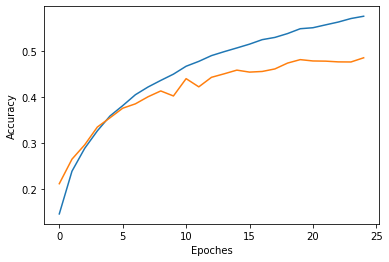

evaluate_LeNet(): time cost = 16.4 minutes
evaluate_LeNet(): Accuracy = 0.4846
evaluate_LeNet(): Recall = 0.48460000000000003
evaluate_LeNet(): Precise = 0.53521174131522
evaluate_LeNet(): F1-score = 0.478332928524274


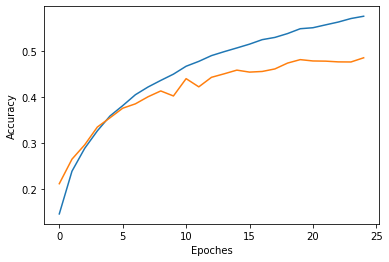

In [7]:
#==================
# Evaluate LeNet-5
#==================
import time
def evaluate_LeNet(x_train, y_train, x_test, y_test, para):
  print("===========================================================")
  print("evaluate_LeNet(): Start LeNet evaluating ")

  start = time.time()

  # parameters 
  best_lr = para[0]
  best_batch = para[2]
  opt = para[1]

  lenet = LeNet(drop = 0.2, summary = False)
  lenet, record = train_LeNet(x_train, y_train, 
              x_test, y_test, 
              lenet, opt = opt,
              batch_size = best_batch, max_epoch = 50, 
              early_stop = True, plot = True, 
              verb = 0)

  # predict on test data 
  prediction = lenet.predict(x_test) 

  # Record time 
  end = time.time()
  time_diff = str(round((end - start)/60, 2))
  print("evaluate_LeNet(): time cost = " + time_diff + " minutes")

  arg_pred=np.argmax(prediction, axis=1)
  arg_test=np.argmax(y_test, axis=1)

  # Accuracy, recall 
  acc = accuracy(arg_test, arg_pred)
  rec = recall(arg_test, arg_pred)
  pre = precision(arg_test, arg_pred)
  f1 = F1(arg_test, arg_pred)

  # log 
  print("evaluate_LeNet(): Accuracy = " + str(acc))
  print("evaluate_LeNet(): Recall = " + str(rec))
  print("evaluate_LeNet(): Precise = " + str(pre))
  print("evaluate_LeNet(): F1-score = " + str(f1))

  plot_epoch_accuracy(record)

  return lenet

default_LeNet_best_para = [0.1, Adadelta(learning_rate = 0.1), 32]
# evaluate CNN
if ('LeNet_best_para' in locals().keys()):
  LeNet_best_model = evaluate_LeNet(NN_x_train, NN_y_train, NN_x_test, NN_y_test, LeNet_best_para)
else:
  LeNet_best_model = evaluate_LeNet(NN_x_train, NN_y_train, NN_x_test, NN_y_test, default_LeNet_best_para)

#### 5.3 Evaluate VGG-16

evaluate_VGG16(): Start VGG16 evaluating 


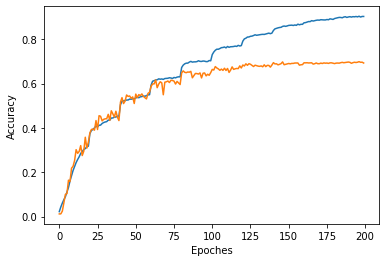

evaluate_VGG16(): time cost = 127.54 minutes
10000
10000
evaluate_VGG16(): Accuracy = 0.693
evaluate_VGG16(): Recall = 0.6929999999999998
evaluate_VGG16(): Precise = 0.7093319486229713
evaluate_VGG16(): F1-score = 0.6939200572633802


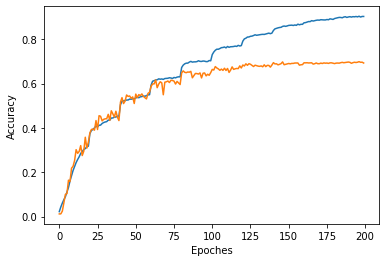

In [9]:
import time 

#================
# Evaluate VGG16
#================

# [decay, lr, batch_size]
def evaluate_VGG16(x_train, y_train, x_test, y_test, para):
  print("===========================================================")
  print("evaluate_VGG16(): Start VGG16 evaluating ")
  # record time 
  start = time.time()

  # parameters 
  best_decay = para[0]
  best_lr = para[1]
  best_batch = para[2]

  # train model 
  VGG_16 = VGG16(kernel = 3, decay = best_decay, summary = False)
  VGG_16, record = train_VGG16(x_train, y_train, 
              x_test, y_test, 
              VGG_16, learning_rate = best_lr, 
              batch_size = best_batch, max_epoch = 200, 
              early_stop = False, plot = True, 
              verb = 0)
  # predict on test data 
  prediction = VGG_16.predict(x_test) 

  # Record time 
  end = time.time()
  time_diff = str(round((end - start)/60, 2))
  print("evaluate_VGG16(): time cost = " + time_diff + " minutes")

  arg_pred=np.argmax(prediction, axis=1)
  arg_test=np.argmax(y_test, axis=1)
  print(len(arg_pred))
  print(len(arg_test))

  # Accuracy, recall 
  acc = accuracy(arg_test, arg_pred)
  rec = recall(arg_test, arg_pred)
  pre = precision(arg_test, arg_pred)
  f1 = F1(arg_test, arg_pred)

  # log 
  print("evaluate_VGG16(): Accuracy = " + str(acc))
  print("evaluate_VGG16(): Recall = " + str(rec))
  print("evaluate_VGG16(): Precise = " + str(pre))
  print("evaluate_VGG16(): F1-score = " + str(f1))

  plot_epoch_accuracy(record)

  return VGG_16

default_VGG16_best_para = [0.0005, 0.1, 128]
  
# evaluate VGG16
if ('VGG16_best_para' in locals().keys()):
  VGG16_best_model = evaluate_VGG16(NN_x_train, NN_y_train, NN_x_test, NN_y_test, VGG16_best_para)
else:
  VGG16_best_model = evaluate_VGG16(NN_x_train, NN_y_train, NN_x_test, NN_y_test, default_VGG16_best_para)

# 6. Save model
Save model will save the best model into h5 file.

#### 6.1 Save model

In [ ]:
from google.colab import files

def save_model(model):
  # download to local
  model.save('/best_model.h5')
  files.download('/best_model.h5')

save_model(VGG16_best_model)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Clean up 

In [ ]:
# Close existing session 
session = get_session()
clear_session()

# free RAM
session.close()


Clean_up()
